# Data and import

## Initial imports

/!\ **fredpy python api is needed to fork data, requires FRED_API_KEY="your_api_key" in file .zshrc and .bashrc** /!\

- Making a request for a key : https://fred.stlouisfed.org/docs/api/api_key.html
- Possibly add FRED_API_KEY="your_api_key" in files .zshrc and .bashrc of computer if code cannot run
- Otherwise try (,api_key="my_api_key") in .get_series of function fred_data
- **Otherwise the data is saved in "data_save.csv"**

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import pyfredapi as pf
import MacroRandomForest as MRF
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from math import *

# Use matplotlib's 'classic' style, set figure facecolor to white
plt.style.use('classic')
plt.rcParams.update({'figure.facecolor': 'white'})
matplotlib.rcParams['figure.figsize'] = [20, 9]

global start_date, end_date, window_dates
start_date = np.datetime64('1980-01-01')
end_date = np.datetime64('2023-12-01')


start_covid = np.datetime64('2020-01-01')
end_covid = np.datetime64("2021-04-01")

start_gfc = np.datetime64("2007-05-01")
end_gfc = np.datetime64("2009-02-01")


current_date = start_date
window_dates = []

while current_date <= end_date:
    window_dates.append(current_date)
    current_date = np.datetime64(current_date, 'M') + np.timedelta64(1, 'M')

window_dates = np.array(window_dates, dtype='datetime64[M]').tolist()

gdpm = pd.read_excel("US-Monthly-GDP-History-Data.xlsx",sheet_name="Data")
gdpm.drop(columns=['Unnamed: 0'],inplace=True)
gdpm.set_index('Date',inplace=True)

In [2]:
df_supp = pd.read_csv("fred_data_new_stat.csv")
df_supp.rename(columns={"Unnamed: 0":"dates"},inplace=True)
df_supp.set_index("dates",drop=True,inplace=True)
df_supp.index.name= None
df_supp.index = pd.to_datetime(df_supp.index)
display(df_supp)

,CAPUTLG3311A2S,IPB52300S,IPCONGD,IPDCONGD,IPG211S,IPG311A2S,IPG321S,BOXRSA,CEXRSA,CHXRSA,...,LNS11300060,LNS11324230,M2REAL,RMFSL,STDSL,LNS14000001,LNS14000002,LNS14000024,LNS14000031,LNS14024887
1990-01-01,-0.189074,-0.009796,-0.016635,-0.104977,-0.012826,0.001509,-0.018170,-0.019281,0.052954,0.014903,...,0.3,-0.2,0.006219,0.289245,100.6,0.000000,-0.018692,0.000000,0.019608,-0.088553
1990-02-01,0.014573,-0.014385,-0.004637,-0.035519,-0.015127,0.017087,0.033864,-0.030994,0.061108,-0.004477,...,0.4,-0.1,0.009344,0.293033,89.9,0.000000,0.057158,0.021979,-0.059423,0.009390
1990-03-01,-0.090188,-0.011562,0.000002,-0.002342,-0.009815,0.023497,0.041804,-0.045522,0.064264,-0.016843,...,0.3,-0.3,0.010496,0.268524,80.9,0.059423,0.019048,0.044452,-0.010257,0.048319
1990-04-01,-0.061485,-0.037694,-0.001996,-0.032354,-0.031473,0.014639,0.023409,-0.050982,0.076825,-0.016820,...,0.2,-0.4,0.017013,0.251271,66.0,0.037740,0.018692,0.042560,-0.030459,0.046091
1990-05-01,-0.026729,-0.047274,0.006120,-0.003543,-0.038434,0.019112,0.016641,-0.059710,0.068197,-0.007260,...,0.3,-0.2,0.018153,0.223297,48.2,0.058269,0.000000,0.043485,-0.031416,0.037740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,-0.029474,0.046433,-0.003722,0.010864,0.079283,-0.016056,-0.064989,0.001537,0.037123,0.043818,...,0.8,-0.5,-0.080221,0.387672,765.1,0.027399,0.000000,0.000000,0.000000,-0.051960
2023-06-01,-0.003815,0.070786,-0.016664,-0.014449,0.079968,-0.038344,-0.069493,0.008131,0.039623,0.040289,...,1.2,-0.3,-0.068631,0.396271,815.0,0.000000,-0.057158,-0.029853,0.088553,-0.076961
2023-07-01,-0.013158,0.074672,-0.003102,0.010560,0.075692,-0.032663,-0.076974,0.012400,0.038515,0.043299,...,1.0,-0.1,-0.071922,0.389250,827.6,0.027399,0.000000,0.000000,-0.055060,0.025318
2023-08-01,-0.003511,0.078169,-0.004581,0.000143,0.076652,-0.036105,-0.063610,0.030946,0.038127,0.049380,...,0.7,0.2,-0.075683,0.408601,811.8,0.077962,0.000000,0.000000,-0.179048,0.097638


In [3]:
# Requested series
REQUEST_LIST = ["CSUSHPISA","FEDFUNDS","DGS10","MORTGAGE30US","REAINTRATREARAT10Y","PSAVERT",
                  "CURRCIR","M2SL","INDPRO","UNRATE","CIVPART","CPIAUCSL","MICH",
                  "PCE","DSPIC96","TTLHHM156N","TOTALSL","DPSACBW027SBOG","MSACSR"]

def fred_data(L:list):
    x = pd.DataFrame(columns=L, index=window_dates)
    
    with tqdm(total=len(L), ascii=True) as pbar:
        for var in L:
            try:
                y = pf.get_series(series_id=var,observation_start=str(start_date),observation_end=str(end_date),frequency="m")
                
                # ===== EDIT HERE IN CASE NEEDED - see comment on fred api at the beginning - edit "my_api_key" with FRED provided api key
                #y = pf.get_series(api_key="my_api_key",series_id=var,observation_start=str(start_date),observation_end=str(end_date),frequency="m")
                # ===========================================================================
                
                y.set_index('date',inplace=True)
                y.drop(columns=["realtime_start","realtime_end"],inplace=True)
                x[var] = y.value
            except:
                None
            pbar.update()
    x['SPREAD'] = x['DGS10'] - x['FEDFUNDS']
    x = x.drop(columns=["FEDFUNDS","DGS10"])
    return x

#TODO: data request
data = fred_data(L=REQUEST_LIST)
data[['GDPn','GDPr']] = gdpm[['GDPn','GDPr']] # Monthly GDP data import

# Indicatrices (was not useful)
data['GFC'] = data.index
data['GFC'] = data['GFC'].apply(lambda x: start_gfc<= x <= end_gfc).apply(lambda x: x*1)
data['Covid'] = data.index
data['Covid'] = data['Covid'].apply(lambda x: start_covid<= x <= end_covid).apply(lambda x: x*1)

data = data.dropna()

display(data)
#data.to_csv("Data_save.csv")

100%|##########| 19/19 [00:04<00:00,  4.09it/s]


,CSUSHPISA,MORTGAGE30US,REAINTRATREARAT10Y,PSAVERT,CURRCIR,M2SL,INDPRO,UNRATE,CIVPART,CPIAUCSL,...,DSPIC96,TTLHHM156N,TOTALSL,DPSACBW027SBOG,MSACSR,SPREAD,GDPn,GDPr,GFC,Covid
1992-01-01,76.087,8.43,3.198542,9.5,304.146,3381.2,61.4898,7.3,66.3,138.300,...,7474.8,95776.0,798.98271,2473.1532,5.2,3.00,6315.725062,10177.847909,0,0
1992-02-01,76.156,8.76,3.628292,9.8,301.542,3400.0,61.9299,7.4,66.2,138.600,...,7507.2,95888.0,799.64038,2484.7280,4.9,3.28,6356.503073,10222.868120,0,0
1992-03-01,76.278,8.94,3.660265,9.7,302.653,3403.9,62.4490,7.4,66.4,139.100,...,7513.8,95984.0,799.44211,2495.0398,6.1,3.56,6417.077864,10307.994876,0,0
1992-04-01,76.346,8.85,3.789860,9.8,305.007,3399.7,62.9312,7.4,66.5,139.400,...,7535.0,96309.0,797.65814,2495.1205,6.1,3.75,6443.259544,10314.363367,0,0
1992-05-01,76.399,8.67,3.746170,9.8,307.800,3398.6,63.1359,7.6,66.6,139.700,...,7570.2,96456.0,797.66790,2484.9213,6.0,3.57,6433.810195,10293.428659,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,302.568,6.43,1.536904,5.3,2333.155,20820.7,102.9240,3.7,62.6,303.294,...,16818.5,130190.0,4959.44635,17274.7781,7.2,-1.49,27073.953429,22255.042049,0,0
2023-06-01,304.593,6.71,1.060631,4.8,2342.699,20854.5,102.3002,3.6,62.6,303.841,...,16809.5,130179.0,4971.61106,17316.8828,7.5,-1.33,27191.380434,22314.750969,0,0
2023-07-01,306.800,6.84,1.426047,4.4,2340.641,20863.7,103.1900,3.5,62.6,304.348,...,16808.4,130278.0,4983.85483,17343.2912,7.1,-1.22,27386.299100,22426.221180,0,0
2023-08-01,309.226,7.07,1.602095,4.4,2330.824,20825.5,103.2411,3.8,62.8,306.269,...,16814.6,130287.0,4969.45447,17325.1125,7.9,-1.16,27624.369911,22505.479995,0,0


## Dataset creation & transformation

In [4]:
# --- 
#TODO: usual transformation for stationarity 
#? "diff_ln" : 100*(log(x_'t') - log(x_'t-12')) = YoY growth rate
#? "diff" : 100*(x_'t' - x_'t-12') = YoY change in ... rate
#? rolling : special case of "MSACSR" : at time t it is the YoY% growth rate between : the number of houses added between (t) and (t)-11 (= over the past year) and the same number but between (t-12) and (t-12)-11 
#? "level" : no change on data

DATA_TRANSFORM = {
"diff_ln":[
"CSUSHPISA",
"CURRCIR",
"M2SL",
"CPIAUCSL",
"INDPRO",
"PCE",
"DSPIC96",
"TTLHHM156N",
"TOTALSL",
"DPSACBW027SBOG",
"GDPr"
],

"diff":[
"MORTGAGE30US",
"REAINTRATREARAT10Y",
"UNRATE",
"CIVPART",
"MICH"
],

"level":[
"SPREAD",
"PSAVERT"
],

"rolling":["MSACSR"]
}

def log_transform(cell_value):
    try:
        return np.log(float(cell_value))
    except (ValueError, TypeError):
        return cell_value

def data_treat(df,treatment):
        
    x = pd.DataFrame(index=df.index)
    for key in treatment:
        if key=="diff_ln":
            x[treatment[key]] = 100*df[treatment[key]].applymap(log_transform).diff(periods=12)
        elif key=="diff":
            x[treatment[key]] = df[treatment[key]].diff(periods=1)
        elif key=="level":
            x[treatment[key]] = df[treatment[key]]
        else:
            x[treatment[key]] = 100*df[treatment[key]].rolling(12).sum().pct_change(periods=12)
    x = x.dropna()
    return x

df_data = data_treat(df=data,treatment=DATA_TRANSFORM)
VARIABLES_LIST = list(df_data.columns)[1::]
#df_data = df_data - df_data.mean()
df_data

,CSUSHPISA,CURRCIR,M2SL,CPIAUCSL,INDPRO,PCE,DSPIC96,TTLHHM156N,TOTALSL,DPSACBW027SBOG,GDPr,MORTGAGE30US,REAINTRATREARAT10Y,UNRATE,CIVPART,MICH,SPREAD,PSAVERT,MSACSR
1993-12-01,2.131694,9.212538,1.443671,2.772180,3.350883,5.270937,1.407186,1.773860,7.125035,1.565067,2.723535,0.01,0.157821,-0.1,0.1,0.2,2.81,9.0,-5.546995
1994-01-01,2.326090,9.357181,1.618834,2.421426,3.267621,5.477629,1.715050,0.985836,7.461335,1.746216,2.868937,-0.11,0.052568,0.1,0.2,-0.2,2.70,7.0,-5.069124
1994-02-01,2.429988,9.836077,1.776483,2.484600,2.851051,6.172477,1.427719,0.994390,7.829006,1.426838,3.278961,0.09,-0.152516,0.0,0.0,0.0,2.72,6.4,-6.106870
1994-03-01,2.554675,10.032467,1.985033,2.617229,3.946258,6.525624,2.063207,0.881876,9.118025,0.968924,3.969991,0.53,0.351034,-0.1,-0.1,0.2,3.14,6.7,-6.018519
1994-04-01,2.630937,10.049516,2.031234,2.336876,4.237189,6.129118,1.543746,1.024158,9.448576,0.392099,3.913022,0.64,0.687980,-0.1,0.0,0.0,3.41,6.3,-3.154574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,-0.398454,2.652660,-3.977345,4.045883,0.143023,5.717823,4.844180,1.675374,5.553885,-4.756079,2.425365,0.09,0.092990,0.3,0.0,-0.5,-1.49,5.3,34.271100
2023-06-01,-0.032825,2.803391,-3.817907,3.045164,-0.376708,5.192728,5.164560,1.601335,5.088911,-4.256655,2.653249,0.28,-0.476273,-0.1,0.0,-0.9,-1.33,4.8,25.763126
2023-07-01,0.965862,2.672625,-3.946734,3.245824,0.055447,5.749568,4.248202,1.656282,4.771788,-4.048647,3.265240,0.13,0.365416,-0.1,0.0,0.1,-1.22,4.4,15.874855
2023-08-01,2.563080,2.416576,-3.927519,3.640429,0.006490,5.280807,3.962187,1.679580,3.903840,-4.065942,2.355520,0.23,0.176048,0.3,0.2,0.1,-1.16,4.4,12.090395


In [5]:
# ---------------------------------- #

#* Steps ahead forecast
for k in [1,3,6]:
    df_data[f"CSUSHPISA+{k}"] = df_data["CSUSHPISA"].shift(periods=-k)

#* > lags [1:3] of all variables
for k in range(1,len(VARIABLES_LIST)):
    if VARIABLES_LIST[k] in ['GFC','Covid']:
        pass
    else:
        for i in range(1,4):
            df_data[f"{VARIABLES_LIST[k]}-{i}"] = df_data[f"{VARIABLES_LIST[k]}"].shift(periods=i)

#* > Lags of dependent variable : up to ...
for k in range(1,4):
    df_data[f"CSUSHPISA-{k}"] = df_data["CSUSHPISA"].shift(periods=k)
    
df_data = df_data.dropna()
df_data = pd.concat([df_data,df_supp],axis=1,join="inner")
df_data

/var/folders/5f/1t5lz7t9659g_zvqs5c0tx180000gn/T/ipykernel_18007/167047086.py:20: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_data = pd.concat([df_data,df_supp],axis=1,join="inner")


,CSUSHPISA,CURRCIR,M2SL,CPIAUCSL,INDPRO,PCE,DSPIC96,TTLHHM156N,TOTALSL,DPSACBW027SBOG,...,LNS11300060,LNS11324230,M2REAL,RMFSL,STDSL,LNS14000001,LNS14000002,LNS14000024,LNS14000031,LNS14024887
1994-03-01,2.554675,10.032467,1.985033,2.617229,3.946258,6.525624,2.063207,0.881876,9.118025,0.968924,...,0.1,0.5,-0.006320,0.013625,-76.8,-0.143101,0.000000,-0.082692,-0.243879,-0.037458
1994-04-01,2.630937,10.049516,2.031234,2.336876,4.237189,6.129118,1.543746,1.024158,9.448576,0.392099,...,0.0,0.6,-0.003082,0.042363,-71.4,-0.145182,-0.061558,-0.133531,-0.238411,-0.036905
1994-05-01,2.796821,9.958343,1.556103,2.262695,5.092129,5.436946,2.836088,1.042950,10.757613,-0.123423,...,-0.1,0.8,-0.007074,0.048068,-62.8,-0.179586,-0.125163,-0.172843,-0.195309,-0.127513
1994-06-01,2.783170,9.964915,1.071970,2.464190,5.535966,5.879996,2.864090,1.058957,11.500371,-0.293920,...,-0.7,0.4,-0.013930,0.033892,-51.2,-0.193191,-0.093819,-0.154151,-0.239017,-0.099699
1994-07-01,2.758989,10.134749,1.333315,2.663182,5.403425,5.479362,2.701568,0.820550,11.555830,0.124052,...,-0.3,0.7,-0.013312,0.047068,-37.4,-0.133531,-0.096850,-0.138150,-0.137201,-0.054916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,7.316355,3.575664,0.390963,6.892278,1.834506,6.648499,-1.651152,1.545816,7.482340,-0.351462,...,0.5,0.1,-0.065013,0.153959,207.7,-0.102654,-0.154151,-0.167054,-0.282863,-0.024098
2022-12-01,5.550672,3.278711,-0.890291,6.245767,0.591787,6.590224,-0.938704,1.604477,7.321320,-0.817413,...,0.5,0.3,-0.071361,0.176218,296.5,-0.137201,-0.108214,-0.117783,-0.307485,0.012121
2023-01-01,3.806496,2.952760,-1.592218,6.153862,1.498379,7.640781,3.189113,1.345614,7.387135,-1.468031,...,0.6,-0.4,-0.077459,0.213888,377.2,-0.130053,-0.167054,-0.145182,-0.278203,-0.036368
2023-02-01,2.168772,2.914879,-2.207235,5.814095,0.872003,7.351409,3.441076,1.335775,6.919619,-1.965042,...,0.9,-0.8,-0.080214,0.252211,469.8,-0.054067,-0.108214,-0.087011,-0.242562,-0.024391


# MRF

## Variable selection

In [6]:
RESULTATS = {"CSUSHPISA+1":pd.DataFrame(index=df_data.index),"CSUSHPISA+3":pd.DataFrame(index=df_data.index),"CSUSHPISA+6":pd.DataFrame(index=df_data.index),"CSUSHPISA+12":pd.DataFrame(index=df_data.index)}

In [7]:
# ================================================================================================ #
#! Based on experience when changing any Y_VAR / X_VAR it is better to restart the kernel an re-run all the code until here to avoid any wrongdoing of the following training bloc - save comments later on

#* -----------------------
###* Dependent Variable

#? (1) One-step ahead
Y_VAR = "CSUSHPISA+1"  

#? (2) 3-step ahead
#Y_VAR = "CSUSHPISA+3"

#? (3) 6-step ahead
#Y_VAR = "CSUSHPISA+6"


#* -----------------------
###* Linear part
#? (1) Baseline
#X_VAR = ["CPIAUCSL","DSPIC96","SPREAD","MORTGAGE30US","UNRATE"]

#? (2) Baseline + HP
X_VAR = ["CSUSHPISA","CPIAUCSL","DSPIC96","SPREAD","MORTGAGE30US","UNRATE"]

#? (2) 2-Lag AR
#X_VAR = ["CSUSHPISA","CSUSHPISA-1","CSUSHPISA-2"]


#* -----------------------
###* Exogenous Variables

#? (1) S_t
S_VAR = ["CSUSHPISA","CPIAUCSL","DSPIC96","SPREAD","MORTGAGE30US","UNRATE"]

#? (2) S_t[0-2]
#svari = ["CSUSHPISA","CPIAUCSL","DSPIC96","SPREAD","MORTGAGE30US","UNRATE"]
#S_VAR = svari + [f"{var}-{i}" for var in svari for i in range(1,3)]

#? (3) High dimensional
#S_VAR = ["CSUSHPISA","CPIAUCSL","DSPIC96","SPREAD","MORTGAGE30US","UNRATE"] + list(df_supp.columns)


# ================================== #
# ================================== #
# Data for the MRF training
data_MRF = pd.DataFrame(index = df_data.index)
data_MRF[[Y_VAR]] = df_data[[Y_VAR]].copy()
data_MRF[X_VAR] = df_data[X_VAR].copy()
data_MRF[S_VAR] = df_data[S_VAR].copy()
data_MRF.T.drop_duplicates().T          #drop duplicate columns if any
Y_pos = data_MRF.columns.get_loc(Y_VAR)
S_pos = [data_MRF.columns.get_loc(s) for s in S_VAR]
X_pos = [data_MRF.columns.get_loc(x) for x in X_VAR]
# ================================== #
# ================================== #


# ======= OOS-WINDOW ============== #
K_OOS = 48
oos_pos = np.arange(len(data_MRF) - K_OOS, len(data_MRF))

# ======= RESULTS ================ #
RESULTATS[Y_VAR]['actual'] = np.nan
RESULTATS[Y_VAR]['actual'].iloc[oos_pos] = df_data[Y_VAR].iloc[oos_pos]

# ================================================================================================ #
display(data_MRF.head())

,CSUSHPISA+1,CSUSHPISA,CPIAUCSL,DSPIC96,SPREAD,MORTGAGE30US,UNRATE
1994-03-01,2.630937,2.554675,2.617229,2.063207,3.14,0.53,-0.1
1994-04-01,2.796821,2.630937,2.336876,1.543746,3.41,0.64,-0.1
1994-05-01,2.783170,2.796821,2.262695,2.836088,3.17,0.28,-0.3
1994-06-01,2.758989,2.783170,2.464190,2.864090,2.85,-0.20,0.0
1994-07-01,2.756298,2.758989,2.663182,2.701568,3.04,0.21,0.0


In [8]:
data_MRF.iloc[oos_pos]

,CSUSHPISA+1,CSUSHPISA,CPIAUCSL,DSPIC96,SPREAD,MORTGAGE30US,UNRATE
2019-04-01,3.282233,3.363008,1.972215,3.388289,0.11,-0.13,-0.1
2019-05-01,3.124265,3.282233,1.777624,3.020761,0.01,-0.07,-0.1
2019-06-01,3.093010,3.124265,1.636223,2.785703,-0.31,-0.27,0.0
2019-07-01,3.093292,3.093010,1.764105,2.478143,-0.34,-0.03,0.1
2019-08-01,3.154620,3.093292,1.731700,2.690118,-0.50,-0.15,-0.1
2019-09-01,3.203099,3.154620,1.702050,2.934692,-0.34,-0.01,-0.1
2019-10-01,3.400690,3.203099,1.753715,2.865433,-0.12,0.08,0.1
2019-11-01,3.701419,3.400690,2.041227,2.978344,0.26,0.01,0.0
2019-12-01,4.009619,3.701419,2.287622,1.143280,0.31,0.02,0.0
2020-01-01,4.262064,4.009619,2.469667,2.237752,0.21,-0.10,0.0


## Initial comments on some code errors due to the package

**If the oos-forecast show too extreme variations / really high spikes and trough for a few months / flat lines : re-run whole code by restarting kernel**

As the process is highly ressource-intensive it appears that when the computer struggles in the forecast phase (especially when the notebook had already been ran) - points are missing and generate abnomrmal spikes/flat lines.
See below for example:

This generates those type of odd results, not due to model miss specification or anything but just due to how the MRF package seem to handle computer struggle.
Reseting the python kernel to run another model seem to solve this problem in most cases.

<div>
<img src="computer_struggle2.png" width="500"/>
</div>

When we look at the predicted coefficients from the MRF some forecasted points are indeed missing, causing the flat lines some are missing for successive dates or a trough when it is a single date missing... 
Only solution is to re-run the code

<div>
<img src="computer_struggle.png" width="500"/>
</div>

For reference this is the correct output (without computer struggle induced missing values).

<div>
<img src="computer_struggle3.png" width="500"/>
</div>

## Model training

In [9]:
# ================================== #
#TODO: /// MRF FIT ///
MRF_model = MRF.MacroRandomForest(data = data_MRF.copy(),
            y_pos = Y_pos,
            x_pos = X_pos,
            S_pos = S_pos,
            mtry_frac=0.75,
            B = 1000,
            parallelise = True,
            n_cores = -1,
            resampling_opt = 2,
            oos_pos = oos_pos,
            trend_push = 4,
            quantile_rate=None,
            ridge_lambda=0.001,
            subsampling_rate=0.65,
            rw_regul=0.75,
            print_b = True,
            fast_rw = True)

# ================================== #
#TODO: /// MRF training ///
MRF_output = MRF_model._ensemble_loop()

Tree 4 out of 1000
Tree 1 out of 1000
Tree 3 out of 1000
Tree 8 out of 1000
Tree 2 out of 1000
Tree 5 out of 1000
Tree 6 out of 1000
Tree 7 out of 1000
Tree 10 out of 1000
Tree 9 out of 1000
Tree 11 out of 1000
Tree 12 out of 1000
Tree 14 out of 1000
Tree 13 out of 1000
Tree 15 out of 1000
Tree 16 out of 1000
Tree 17 out of 1000
Tree 18 out of 1000
Tree 19 out of 1000
Tree 20 out of 1000
Tree 21 out of 1000
Tree 22 out of 1000
Tree 23 out of 1000
Tree 24 out of 1000
Tree 27 out of 1000
Tree 26 out of 1000
Tree 25 out of 1000
Tree 29 out of 1000
Tree 28 out of 1000
Tree 30 out of 1000
Tree 31 out of 1000
Tree 32 out of 1000
Tree 33 out of 1000
Tree 34 out of 1000
Tree 35 out of 1000
Tree 36 out of 1000
Tree 38 out of 1000
Tree 39 out of 1000
Tree 37 out of 1000
Tree 40 out of 1000
Tree 41 out of 1000
Tree 42 out of 1000
Tree 43 out of 1000
Tree 44 out of 1000
Tree 45 out of 1000
Tree 46 out of 1000
Tree 47 out of 1000
Tree 48 out of 1000
Tree 49 out of 1000
Tree 50 out of 1000
Tree 51 o

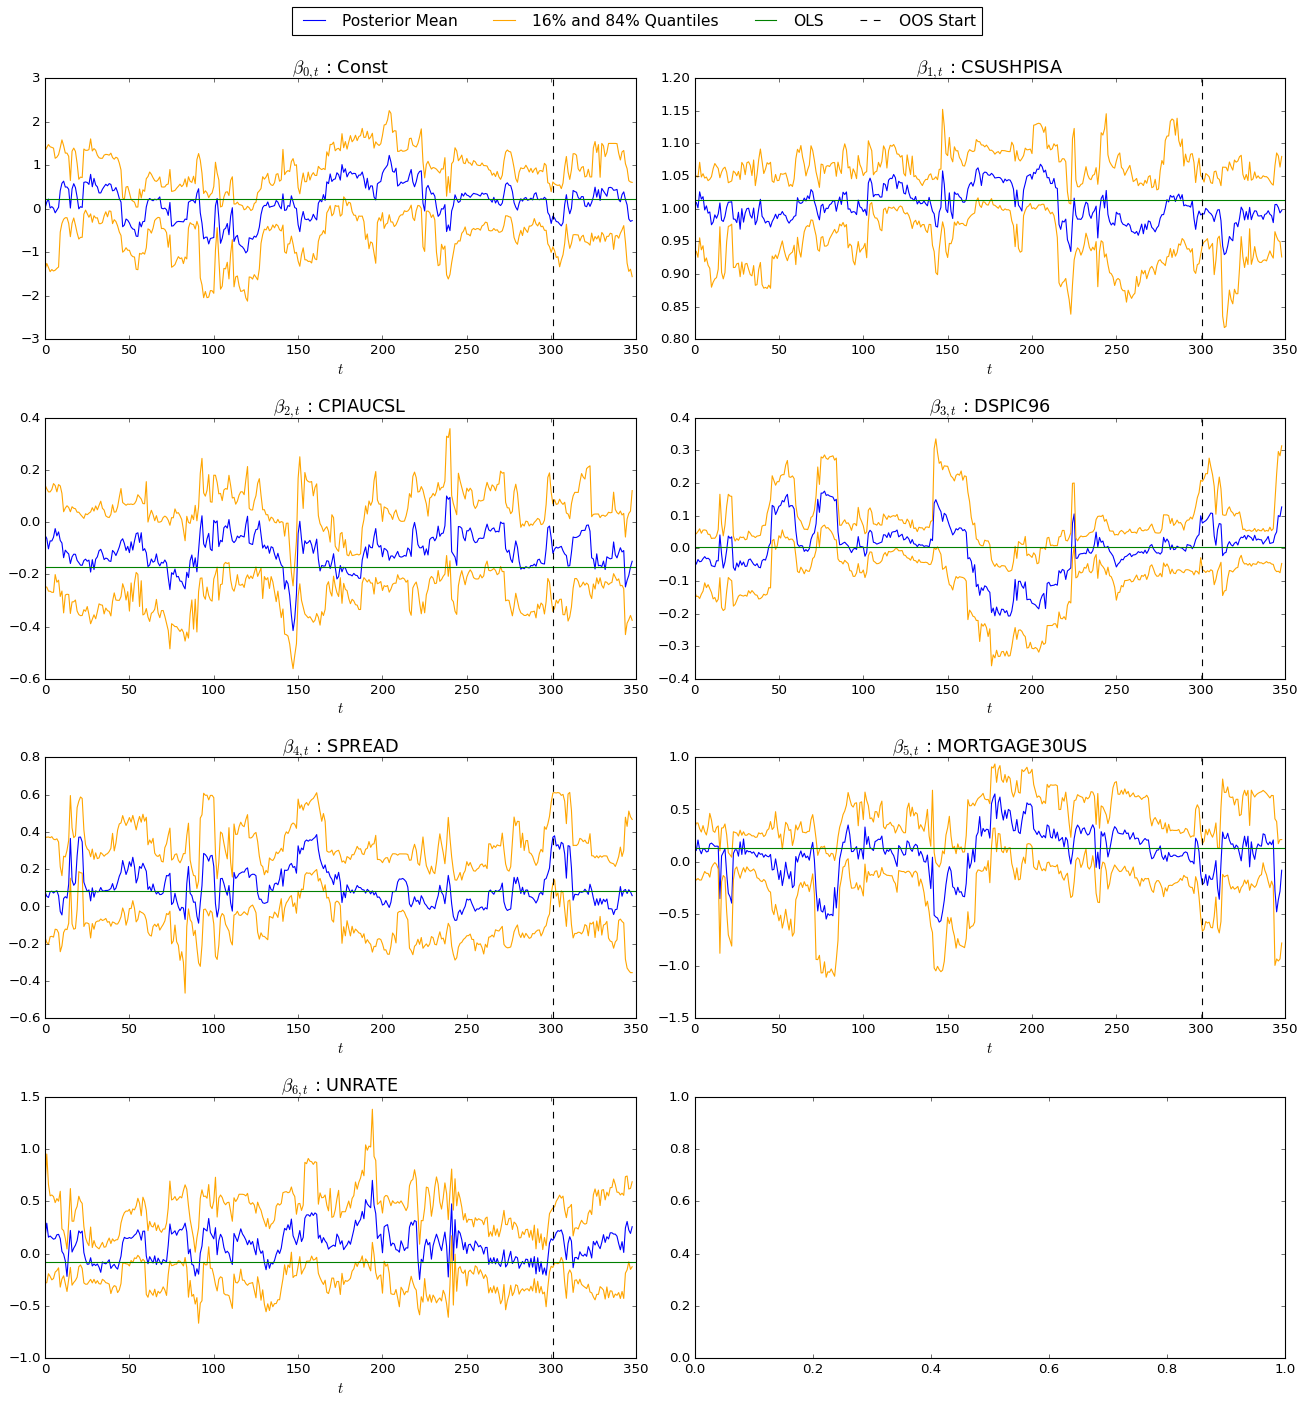

In [10]:
# Display time-varying parameters
MRF_model.band_plots()

In [11]:
# Compute results
beta_res = pd.DataFrame(MRF_output['betas'],index=data_MRF.index,columns=['const']+X_VAR)
fit_res = pd.DataFrame(index=beta_res.index)
for x in X_VAR:
    fit_res[x] = beta_res[x]*df_data[x]
fit_res['const'] = beta_res['const']

fit_res['training'] = fit_res.sum(axis=1)
fit_res['oos'] = fit_res['training']
fit_res['training'].iloc[oos_pos] = np.nan
fit_res['oos'].iloc[:len(fit_res)-len(oos_pos)] = np.nan
fit_res['actual'] = df_data[Y_VAR]
fit_res

RESULTATS[Y_VAR]['OOS'] = fit_res['oos']

<Axes: >

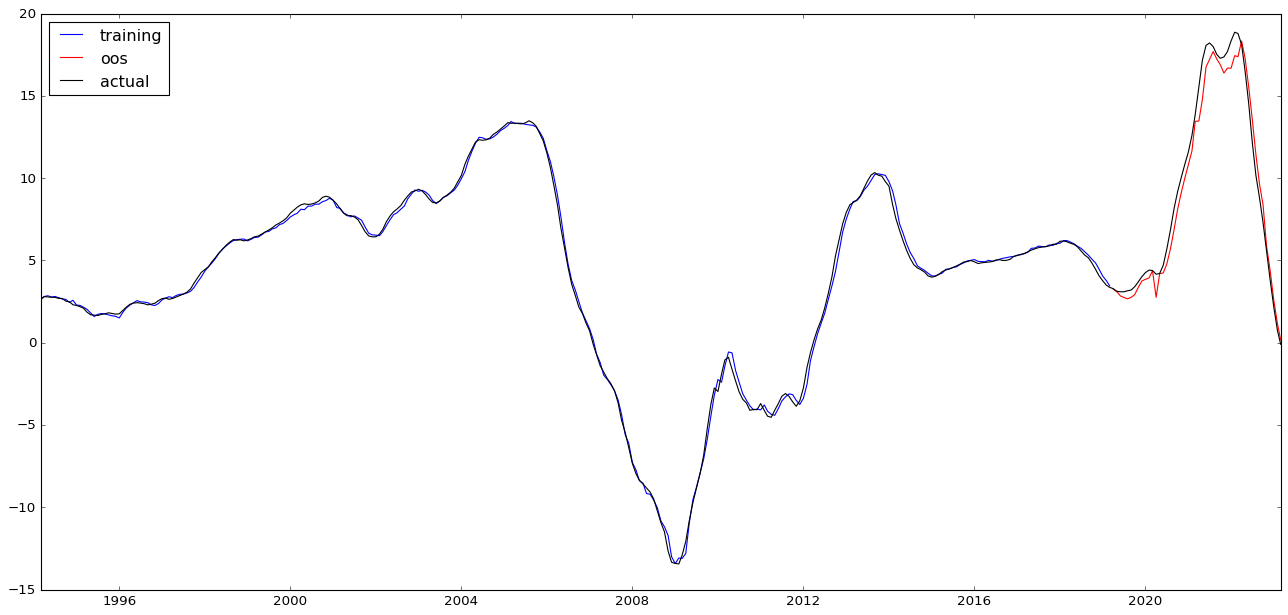

In [12]:
display(fit_res[['training','oos','actual']].plot(color=['blue','red','black']))

<Axes: >

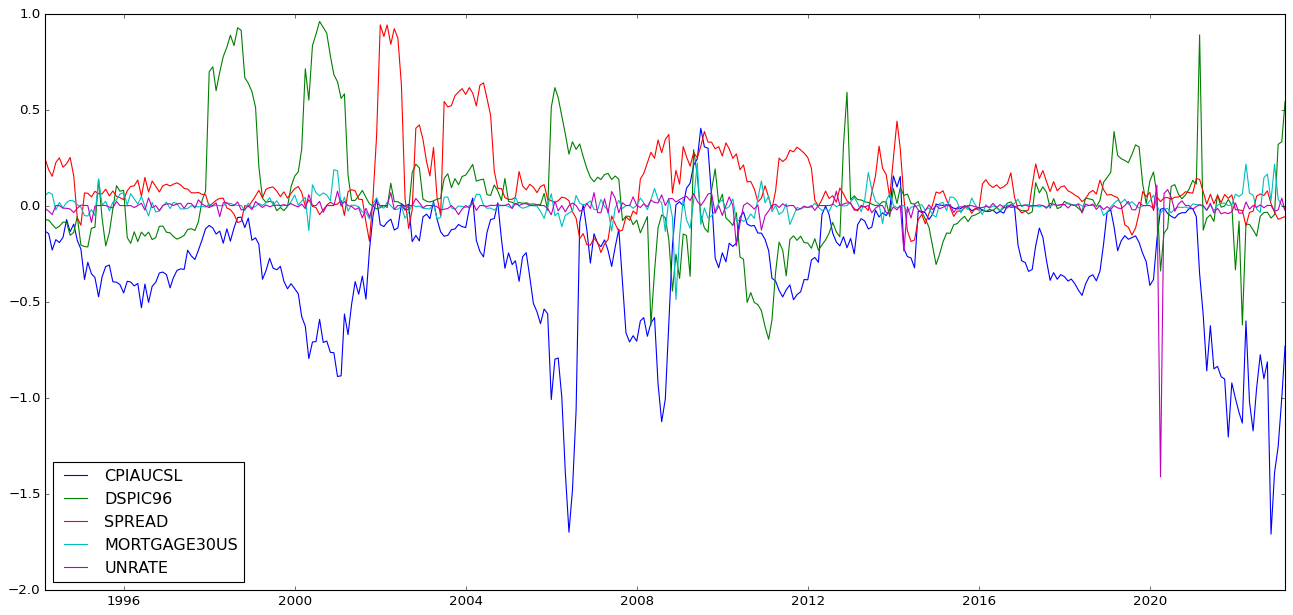

In [19]:
fit_res[[cols for cols in fit_res.columns[1:len(fit_res.columns)-4]]].plot()

In [13]:
#print(r2_score(y_true=RESULTATS[Y_VAR].iloc[oos_pos]["actual"],y_pred=RESULTATS[Y_VAR].iloc[oos_pos]["OOS"]))
print(sqrt(mean_squared_error(y_true=RESULTATS[Y_VAR].iloc[oos_pos]["actual"],y_pred=RESULTATS[Y_VAR].iloc[oos_pos]["OOS"])))

0.928220787426279


<Axes: >

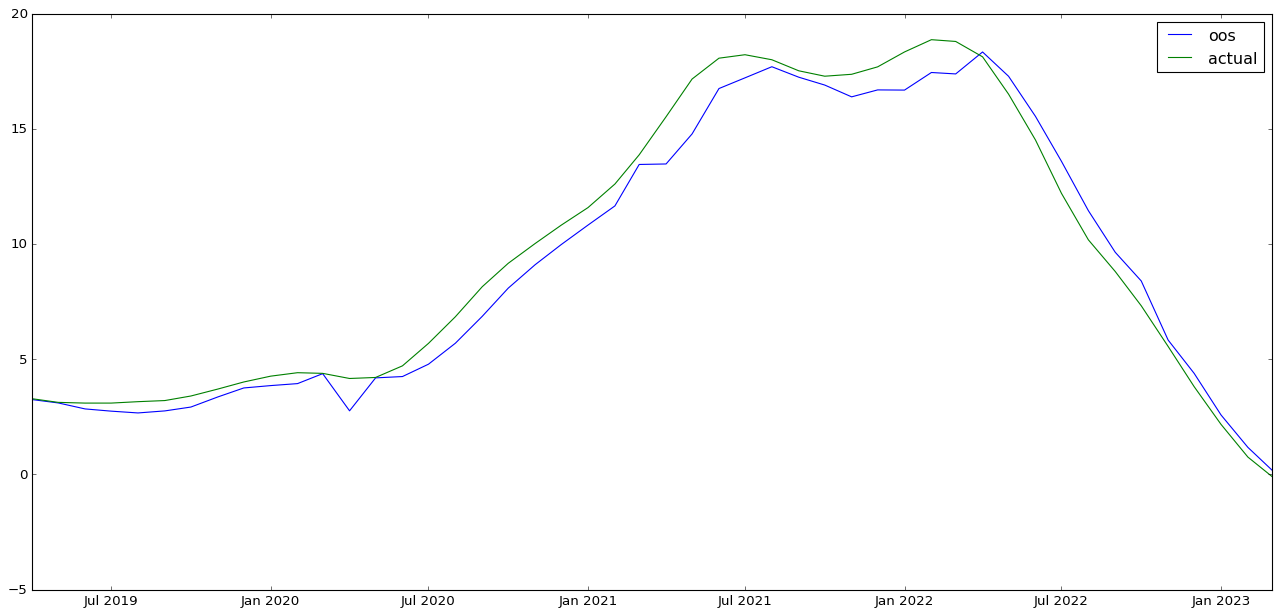

In [14]:
fit_res[["oos","actual"]].iloc[oos_pos].plot()

# Plain RF

In [ ]:
Y_VAR = "CSUSHPISA+3"
#Y_VAR = "CSUSHPISA+6"

In [ ]:
def prepareDataForClassificationRF(dataset,x_reg,y_reg,oos=48):
    """
    generates categorical output column, which is then used
    to create the train and test data
    """ 
    dataset_rf = dataset.copy().reset_index()
    X = (dataset_rf[x_reg])
    y = (dataset_rf[y_reg])
    
    X_train = X.iloc[0:len(X) - oos]
    y_train = y.iloc[0:len(y) - oos]
    
    X_test = X.iloc[len(X) - oos::]
    y_test = y.iloc[len(y) - oos::]
    
    train_index, test_index = dataset.index[0:len(X) - oos], dataset.index[len(X) - oos::]
    
    return X_train, y_train, X_test, y_test, train_index, test_index, dataset

#? Plain RF
#xvar_rf = ["CSUSHPISA","CPIAUCSL","DSPIC96","SPREAD","MORTGAGE30US","UNRATE"]

#? Plain RF-AR(2)
rfbase = ["CSUSHPISA"]
xvar_rf = rfbase + [f"{var}-{i}" for var in rfbase for i in range(1,3)]

#? Plain RF-AR(2) Augmented
#rfbase = ["CSUSHPISA","CPIAUCSL","DSPIC96","SPREAD","MORTGAGE30US","UNRATE"] # [X,HP]_t 
#xvar_rf = rfbase + [f"{var}-{i}" for var in rfbase for i in range(1,3)]

X_train, y_train, X_test, y_test, train_index, test_index, dataset  = prepareDataForClassificationRF(dataset=df_data,x_reg=xvar_rf,y_reg=Y_VAR)

In [ ]:
RF_Model = RandomForestRegressor(n_estimators=1000,
                                 max_features=0.60, oob_score=False,
                                 min_samples_split=20)
labels = y_train
features = X_train
rgr=RF_Model.fit(features, labels)
X_test_predict=pd.DataFrame(rgr.predict(X_test), index=test_index)
X_train_predict=pd.DataFrame(rgr.predict(X_train), index=train_index)
RF_predict = X_train_predict.append(X_test_predict).rename(columns={0:'plain_RF_predict'})
RF_predict['actual'] = df_data[Y_VAR].copy()
print("R2_score : ",r2_score(y_true=RF_predict.iloc[oos_pos]['actual'],y_pred=RF_predict.iloc[oos_pos]['plain_RF_predict']))
print("RMSE : ",sqrt(mean_squared_error(y_true=RF_predict.iloc[oos_pos]['actual'],y_pred=RF_predict.iloc[oos_pos]['plain_RF_predict'])))

RF_predict_result = pd.DataFrame(index=RF_predict.index)
RF_predict_result[["training","oos","actual"]] = ""
RF_predict_result["training"].iloc[:len(RF_predict_result)-48] = RF_predict["plain_RF_predict"].iloc[:len(RF_predict_result)-48]
RF_predict_result["training"].iloc[len(RF_predict_result)-48::] = np.nan
RF_predict_result["oos"].iloc[len(RF_predict_result)-48::] = RF_predict["plain_RF_predict"].iloc[len(RF_predict_result)-48::]
RF_predict_result["oos"].iloc[:len(RF_predict_result)-48] = np.nan
RF_predict_result["actual"] = RF_predict["actual"]
RF_predict_result.plot(color=['blue','red','black'])